In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from pyimgy.optional.torch import *

from netlens.modules import Normalization
from netlens.style_transfer import *

Next, we need to choose which device to run the network on and import the
content and style images. Running the neural transfer algorithm on large
images takes longer and will go much faster when running on a GPU. We can
use ``torch.cuda.is_available()`` to detect if there is a GPU available.
Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)``
method is used to move tensors or modules to a desired device. 



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(device)

cpu


### Optional: clearing CUDA memory

In [7]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    from pynvml import *
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print("Total memory:", info.total)
    print("Free memory:", info.free)
    print("Used memory:", info.used)
    
    torch.cuda.memory_allocated()

### Loading the Images

In [12]:
import urllib 
def load(url):
    img = PIL.Image.open(urllib.request.urlopen(url))
    return np.array(img)

(512, 512, 3) (512, 645, 3)


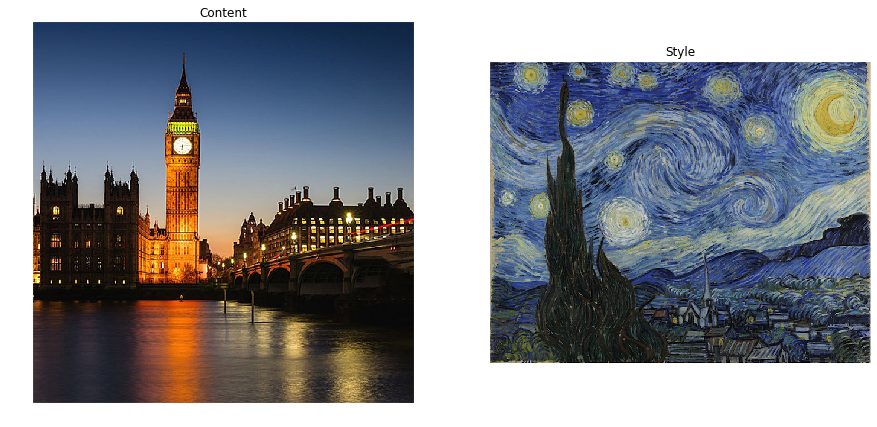

In [13]:
# how to load images from URLs

content_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/notebook-styletransfer-bigben.jpg")
style_image = load("https://storage.googleapis.com/tensorflow-lucid/static/img/starry-night.png")[..., :3] # removes transparency channel

print(content_image.shape, style_image.shape)

show_images([content_image, style_image], ['Content', 'Style'])

In [14]:
import torchvision.transforms as T

def transform_inputs(content_image, style_image):
    content_tfms = T.ToTensor()
    content_input = content_tfms(content_image).unsqueeze(0)
    style_tfms = T.Compose([T.ToPILImage(), T.RandomCrop(content_image.shape[:2]), T.ToTensor()])
    style_input = style_tfms(style_image).unsqueeze(0)
    return content_input, style_input

In [15]:
content_img, style_img = transform_inputs(content_image, style_image)

In [16]:
type(content_img), content_img.shape, content_img.max(), style_img.shape

(torch.Tensor,
 torch.Size([1, 3, 512, 512]),
 tensor(1.),
 torch.Size([1, 3, 512, 512]))

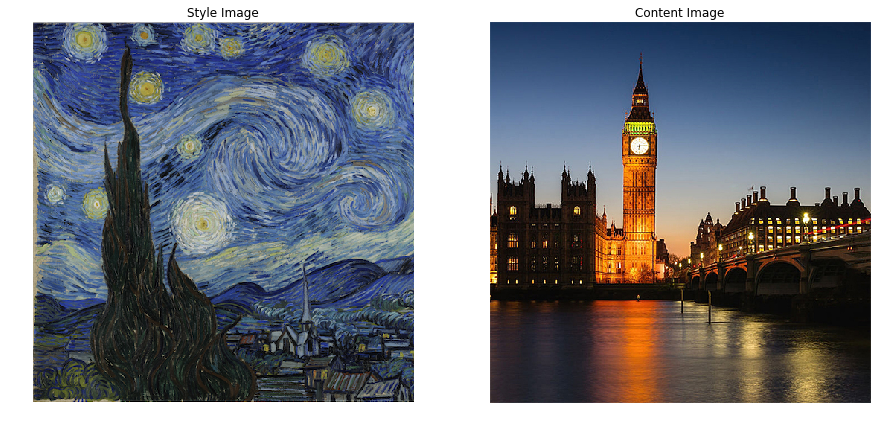

In [17]:
show_images([style_img, content_img], ['Style Image', 'Content Image'])

Importing the Model
-------------------

Now we need to import a pre-trained neural network. We will use a 19
layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child
``Sequential`` modules: ``features`` (containing convolution and pooling layers),
and ``classifier`` (containing fully connected layers). We will use the
``features`` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using ``.eval()``.




In [18]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Additionally, VGG networks are trained on images with each channel
normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
We will use them to normalize the image before sending it into the network.




In [19]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

A ``Sequential`` module contains an ordered list of child modules. For
instance, ``vgg19.features`` contains a sequence (Conv2d, ReLU, MaxPool2d,
Conv2d, ReLU…) aligned in the right order of depth. We need to add our
content loss and style loss layers immediately after the convolution
layer they are detecting. To do this we must create a new ``Sequential``
module that has content loss and style loss modules correctly inserted.




In [16]:
arch = FlatModel.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

In [17]:
style_injects = [f'conv-{i}' for i in range(5)]
content_injects = ['conv-3']

In [ ]:
content_img = content_img.cuda()
style_img = style_img.cuda()

In [19]:
style_module = StyleTransferModule(arch, content_img, content_injects, style_img, style_injects)

In [20]:
style_module

StyleTransferModule(
  (layers): ModuleDict(
    (normalization-0): Normalization()
    (conv-0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-0): FeatureLoss()
    (relu-0): ReLU()
    (conv-1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-1): FeatureLoss()
    (relu-1): ReLU()
    (pool-0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-2): FeatureLoss()
    (relu-2): ReLU()
    (conv-3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-3): FeatureLoss()
    (content_loss-3): FeatureLoss()
    (relu-3): ReLU()
    (pool-1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv-4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (style_loss-4): FeatureLoss()
  )
)

In [21]:
len(style_module.layers)

18

In [22]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('style_loss')]

[tensor(0.9748),
 tensor(33.0196),
 tensor(451.5322),
 tensor(757.6630),
 tensor(2949.6160)]

In [23]:
[m.target.sum() for k, m in style_module.layers.items() if k.startswith('content_loss')]

[tensor(-12774262.)]

Next, we select the input image. You can use a copy of the content image
or white noise.




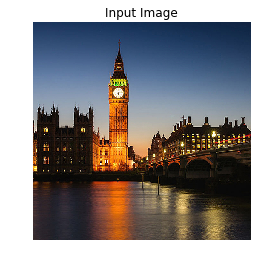

In [24]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

show_image(input_img, 'Input Image')

Gradient Descent
----------------

As Leon Gatys, the author of the algorithm, suggested `here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__, we will use
L-BFGS algorithm to run our gradient descent. Unlike training a network,
we want to train the input image in order to minimise the content/style
losses. We will create a PyTorch L-BFGS optimizer ``optim.LBFGS`` and pass
our image to it as the tensor to optimize.




Finally, we must define a function that performs the neural transfer. For
each iteration of the networks, it is fed an updated input and computes
new losses. We will run the ``backward`` methods of each loss module to
dynamicaly compute their gradients. The optimizer requires a “closure”
function, which reevaluates the modul and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.




Finally, we can run the algorithm.

In [25]:
content_img.shape[-2:]

torch.Size([512, 512])

In [30]:
from netlens.visualization import param

num_steps=300
style_weight=1000000
content_weight=1
tv_weight=1e-3

# create objective from the module and the weights
objective = StyleTransferObjective(style_module, style_weight, content_weight, tv_weight)
# the "parameterized" image is the image itself
# param_img = RawParam(input_img, cloned=True)
param_img = param.ImageParam(content_img.shape[-2:], fft=True, decorrelate=True) 
render = OptVis(style_module, objective, optim=optim.LBFGS)
thresh = (num_steps,) if isinstance(num_steps, int) else num_steps


Run [50], loss=15408.9258
Style loss=15349.23046875, Content loss=41.61103439331055, TV loss=18.08411979675293
Run [100], loss=13735.8066
Style loss=13673.806640625, Content loss=44.77509307861328, TV loss=17.224903106689453
Run [150], loss=17427.4922
Style loss=17381.107421875, Content loss=37.220516204833984, TV loss=9.164360046386719
Run [200], loss=11474.9941
Style loss=11416.197265625, Content loss=41.0901985168457, TV loss=17.706876754760742
Run [250], loss=9697.1562
Style loss=9636.068359375, Content loss=41.164669036865234, TV loss=19.92245101928711
Run [300], loss=7231.4023


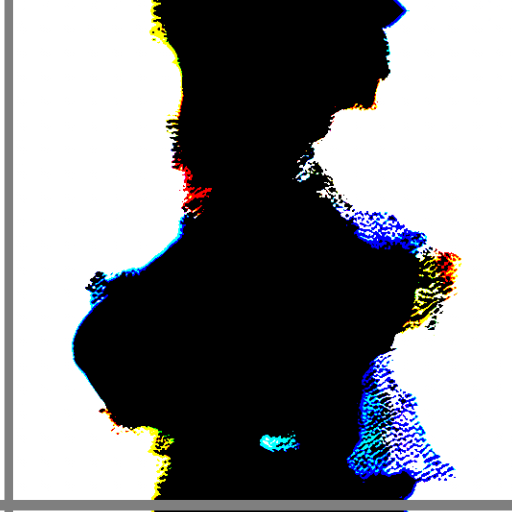

Style loss=7162.16845703125, Content loss=45.23855209350586, TV loss=23.9953556060791


In [31]:
output = render.vis(param_img, thresh, in_closure=True, callback=STCallback(), show=True)

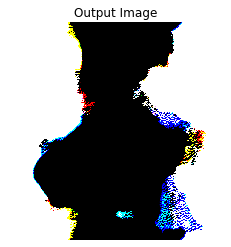

In [32]:
show_image(output, 'Output Image')

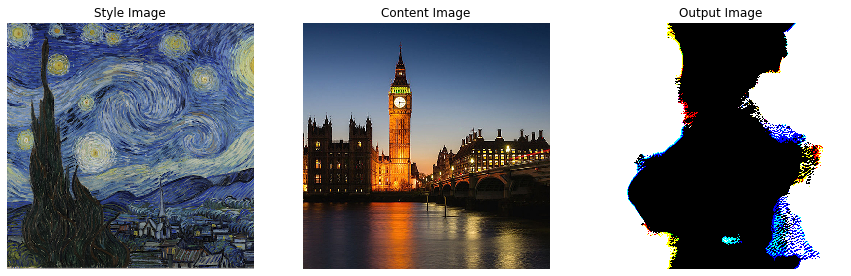

In [33]:
show_images([style_img, content_img, output], ['Style Image', 'Content Image', 'Output Image'])